## Download and preprocess drug response data from GDSC

* Drug responses come from processed data in [Sharifi-Noghabi et al. 2019](https://doi.org/10.1093/bioinformatics/btz318)
* Cell lines are binarized into resistant/sensitive for each drug as described in [Iorio et al. 2016](https://doi.org/10.1016/j.cell.2016.06.017) (see Table S5 and associated supplementary details)

In [1]:
import glob
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg

In [2]:
# drug to visualize sample proportions for
# valid drugs: 5-Fluorouracil, Afatinib, Bortezomib, Cetuximab, Cisplatin, Docetaxel,
# EGFRi, Erlotinib, Gefitinib, Gemcitabine, Lapatinib, Paclitaxel, Tamoxifen
drug_to_plot = 'Trametinib_2'

# where to save plots
output_plots = True
output_plots_dir = (
    cfg.repo_root / '08_cell_line_prediction' / 'drug_response_dists'
)
output_plots_dir.mkdir(exist_ok=True)

### Download drug response data

In [3]:
drug_response_file = cfg.cell_line_drug_response / 'response.tar.gz'
decompress_dir = cfg.cell_line_drug_response / 'raw_response'

if not os.path.exists(drug_response_file):
    cfg.cell_line_drug_response.mkdir(exist_ok=True)
    
    # retrieve compressed response data
    from urllib.request import urlretrieve
    url = 'https://zenodo.org/record/4036592/files/response.tar.gz?download=1'
    urlretrieve(url, drug_response_file)
    
    # decompress response data
    decompressed_location = cfg.cell_line_drug_response / 'response'
    !tar -xvzf $drug_response_file -C $cfg.cell_line_drug_response
    !mv $decompressed_location $decompress_dir
else:
    print('Downloaded response data from MOLI paper already exists, skipping download')

Downloaded response data from MOLI paper already exists, skipping download


### Merge drug response files into binary matrix

In [4]:
drug_labels = {}
all_index = None
for fname in glob.glob(str(decompress_dir / 'GDSC_response.*.tsv')):
    print(fname, file=sys.stderr)
    # skip combined EGFRi data for now, we'll deal with it next
    # we want to look at the drugs independently
    if 'EGFRi' in fname:
        continue
    drug_df = pd.read_csv(fname, sep='\t', index_col=0)
    drug_df.index.name = 'COSMICID'
    drug_name = os.path.basename(fname).split('.')[1]
    if 'drug' in drug_df.columns:
        assert drug_df.drug.unique().shape[0] == 1
    # 0 = resistant, 1 = sensitive
    drug_labels[drug_name] = (drug_df.response
        .replace(to_replace='R', value='0')
        .replace(to_replace='S', value='1')
    )
    # make sure everything was labeled
    assert set(drug_labels[drug_name].unique()).issubset(set(['0', '1', np.nan]))
    # get union of all indexes
    if all_index is None:
        all_index = drug_labels[drug_name].index
    else:
        all_index = all_index.union(drug_labels[drug_name].index)
        
# reindex all response series with union of indexes
drug_labels = {
    n: s.reindex(all_index) for n, s in drug_labels.items()
}
# convert to matrix
drugs_df = pd.DataFrame(drug_labels, index=all_index)

print(drugs_df.shape)
drugs_df.head()

(954, 15)


/home/jake/research/pancancer-evaluation/data/ccle/drug_response/raw_response/GDSC_response.Trametinib_2.tsv
/home/jake/research/pancancer-evaluation/data/ccle/drug_response/raw_response/GDSC_response.Gefitinib.tsv
/home/jake/research/pancancer-evaluation/data/ccle/drug_response/raw_response/GDSC_response.Afatinib.tsv
/home/jake/research/pancancer-evaluation/data/ccle/drug_response/raw_response/GDSC_response.Paclitaxel.tsv
/home/jake/research/pancancer-evaluation/data/ccle/drug_response/raw_response/GDSC_response.5-Fluorouracil.tsv
/home/jake/research/pancancer-evaluation/data/ccle/drug_response/raw_response/GDSC_response.Cetuximab.tsv
/home/jake/research/pancancer-evaluation/data/ccle/drug_response/raw_response/GDSC_response.AZD6244_0.tsv
/home/jake/research/pancancer-evaluation/data/ccle/drug_response/raw_response/GDSC_response.Erlotinib.tsv
/home/jake/research/pancancer-evaluation/data/ccle/drug_response/raw_response/GDSC_response.EGFRi.tsv
/home/jake/research/pancancer-evaluation/d

,Trametinib_2,Gefitinib,Afatinib,Paclitaxel,5-Fluorouracil,Cetuximab,AZD6244_0,Erlotinib,Bortezomib,Docetaxel,Lapatinib,Cisplatin,Tamoxifen,AZD6244_1,Gemcitabine
COSMICID,,,,,,,,,,,,,,,
683665,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
683667,NaN,0,0,NaN,0,NaN,0,NaN,NaN,0,NaN,0,0,NaN,0
684052,0,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,0
684055,0,NaN,NaN,0,0,1,1,0,0,NaN,0,NaN,0,0,0
684057,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [5]:
drugs_df.to_csv(cfg.cell_line_drug_response_matrix, sep='\t')

In [6]:
# deal with EGFRi data here
fname = str(decompress_dir / 'GDSC_response.EGFRi.tsv')
drug_df = pd.read_csv(fname, sep='\t', index_col=0)
drug_df.head()

,response,logIC50,drug,exprs,CNA,mutations
sample_name,,,,,,
683665,R,6.294447,Cetuximab,1,1,1
683665,R,2.436586,Erlotinib,1,1,1
683665,R,2.684181,Lapatinib,1,1,1
683665,R,1.464855,Gefitinib,1,1,1
683665,R,1.490015,Afatinib,1,1,1


In [7]:
# get the list of samples that are assayed for at least one EGFR inhibitor
all_index = None
for drug in drug_df.drug.unique():
    drug_specific_df = drug_df[drug_df.drug == drug]
    if all_index is None:
        all_index = drug_specific_df.index
    else:
        all_index = all_index.union(drug_specific_df.index)
    print(drug, drug_specific_df.shape)
    
print(all_index.shape)

Cetuximab (856, 6)
Erlotinib (362, 6)
Lapatinib (387, 6)
Gefitinib (825, 6)
Afatinib (828, 6)
(940,)


In [8]:
# here we want to get the union of EGFRi-sensitive cell lines
# in other words, if a cell line is sensitive to any of the EGFR
# inhibitors, we mark it as sensitive, otherwise resistant
all_egfri_df = None
for drug in drug_df.drug.unique():
    drug_specific_df = (drug_df[drug_df.drug == drug]
      .reindex(all_index)
      .fillna(0)
    )  
    # 0 = resistant, 1 = sensitive
    drug_specific_df['response'] = (drug_specific_df.response
        .replace(to_replace='R', value='0')
        .replace(to_replace='S', value='1')
        .astype(int)
    )
    if all_egfri_df is None:
        all_egfri_df = (drug_specific_df
          .loc[:, ['response']]
          .rename(columns={'response': 'EGFRi'})
        )
    else:
        all_egfri_df['EGFRi'] += (
            drug_specific_df.response
        )
        
all_egfri_df.index.name = 'COSMICID'
all_egfri_df['EGFRi'] = all_egfri_df.EGFRi.astype(bool).astype(int)
        
print(all_egfri_df.shape) 
print(all_egfri_df.EGFRi.value_counts())
all_egfri_df.head()

(940, 1)
0    642
1    298
Name: EGFRi, dtype: int64


,EGFRi
COSMICID,
683665,0
683667,0
684052,0
684055,1
684057,0


In [9]:
all_egfri_df.to_csv(cfg.cell_line_drug_response_egfri, sep='\t')

### Load CCLE sample info

In [10]:
ccle_sample_info_df = pd.read_csv(cfg.ccle_sample_info, sep=',', index_col=0)
ccle_expression_samples_df = pd.read_csv(cfg.ccle_expression, sep=',',
                                         index_col=0, usecols=[0])

In [11]:
print(ccle_sample_info_df.columns)
ccle_sample_info_df.iloc[:5, :5]

Index(['cell_line_name', 'stripped_cell_line_name', 'CCLE_Name', 'alias',
       'COSMICID', 'sex', 'source', 'RRID', 'WTSI_Master_Cell_ID',
       'sample_collection_site', 'primary_or_metastasis', 'primary_disease',
       'Subtype', 'age', 'Sanger_Model_ID', 'depmap_public_comments',
       'lineage', 'lineage_subtype', 'lineage_sub_subtype',
       'lineage_molecular_subtype', 'default_growth_pattern',
       'model_manipulation', 'model_manipulation_details', 'patient_id',
       'parent_depmap_id', 'Cellosaurus_NCIt_disease', 'Cellosaurus_NCIt_id',
       'Cellosaurus_issues'],
      dtype='object')


,cell_line_name,stripped_cell_line_name,CCLE_Name,alias,COSMICID
DepMap_ID,,,,,
ACH-000016,SLR 21,SLR21,SLR21_KIDNEY,NaN,NaN
ACH-000032,MHH-CALL-3,MHHCALL3,MHHCALL3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN
ACH-000033,NCI-H1819,NCIH1819,NCIH1819_LUNG,NaN,NaN
ACH-000043,Hs 895.T,HS895T,HS895T_FIBROBLAST,NaN,NaN
ACH-000049,HEK TE,HEKTE,HEKTE_KIDNEY,NaN,NaN


In [12]:
ccle_expression_samples_df.head()

""
ACH-001113
ACH-001289
ACH-001339
ACH-001538
ACH-000242


In [13]:
ccle_samples = ccle_expression_samples_df.index.intersection(ccle_sample_info_df.index)
ccle_to_cosmic_id = (ccle_sample_info_df
    .reindex(ccle_samples)
    .COSMICID
    .dropna()
    .astype(int)
)

print(ccle_samples.shape,ccle_to_cosmic_id.shape)
ccle_to_cosmic_id[:5]

(1406,) (700,)


ACH-000242     687455
ACH-000708    1659929
ACH-000327     684681
ACH-000233     906836
ACH-000528     906791
Name: COSMICID, dtype: int64

In [14]:
ccle_cancer_types = (ccle_sample_info_df
    .reindex(ccle_samples)
    .groupby('primary_disease')
    .count()
    .reset_index()
    .iloc[:, [0, 1]]
    .rename(columns={'cell_line_name': 'count'})
)

ccle_cancer_types.head()

,primary_disease,count
0,Adrenal Cancer,1
1,Bile Duct Cancer,35
2,Bladder Cancer,36
3,Bone Cancer,38
4,Brain Cancer,80


### Check distribution of labeled samples across cancer types

In [28]:
if drug_to_plot == 'EGFRi':
    drug_response_df = (all_egfri_df
        .reset_index()
        .rename(columns={'COSMICID': 'sample_name', 'EGFRi': 'response'})
    )
    drug_response_df['response'] = (drug_response_df.response
        .replace(to_replace='0', value='R')
        .replace(to_replace='1', value='S')
        .astype(str)
    )
    drug_response_df['drug'] = 'EGFRi'
else:
    drug_response_df = pd.read_csv(
        decompress_dir / 'GDSC_response.{}.tsv'.format(drug_to_plot), sep='\t'
    )
    if 'Trametinib' in drug_to_plot:
        drug_response_df = (drug_response_df
            .rename(columns={'cell_line': 'sample_name'})
            .dropna(subset=['response'])
        )
        drug_response_df['drug'] = 'Trametinib'

print(drug_response_df.shape)
drug_response_df.head()

(877, 6)


,sample_name,response,exprs,CNA,mutations,drug
0,683665,R,1,1,1,Trametinib
2,684052,R,1,1,1,Trametinib
3,684055,R,1,1,1,Trametinib
4,684057,R,1,1,1,Trametinib
5,684059,R,1,1,1,Trametinib


In [29]:
ccle_drug_label_overlap = (
    set(drug_response_df.sample_name).intersection(
    set(ccle_to_cosmic_id.values))
)
    
print(len(ccle_drug_label_overlap))
print(list(ccle_drug_label_overlap)[:5])

615
[907269, 907270, 907271, 907273, 907274]


In [30]:
ccle_label_cancer_types = (ccle_sample_info_df
    [ccle_sample_info_df.COSMICID.isin(ccle_drug_label_overlap)]
    .groupby('primary_disease')
    .count()
    .reset_index()
    .iloc[:, [0, 1]]
    .rename(columns={'cell_line_name': 'labeled_count'})
    .merge(ccle_cancer_types, how='right', on='primary_disease')
    .fillna(value=0)
)

ccle_label_cancer_types['labeled_proportion'] = (
    ccle_label_cancer_types['labeled_count'] / ccle_label_cancer_types['count']
)

ccle_label_cancer_types.head()

,primary_disease,labeled_count,count,labeled_proportion
0,Adrenal Cancer,1.0,1,1.000000
1,Bile Duct Cancer,2.0,35,0.057143
2,Bladder Cancer,13.0,36,0.361111
3,Bone Cancer,14.0,38,0.368421
4,Brain Cancer,37.0,80,0.462500


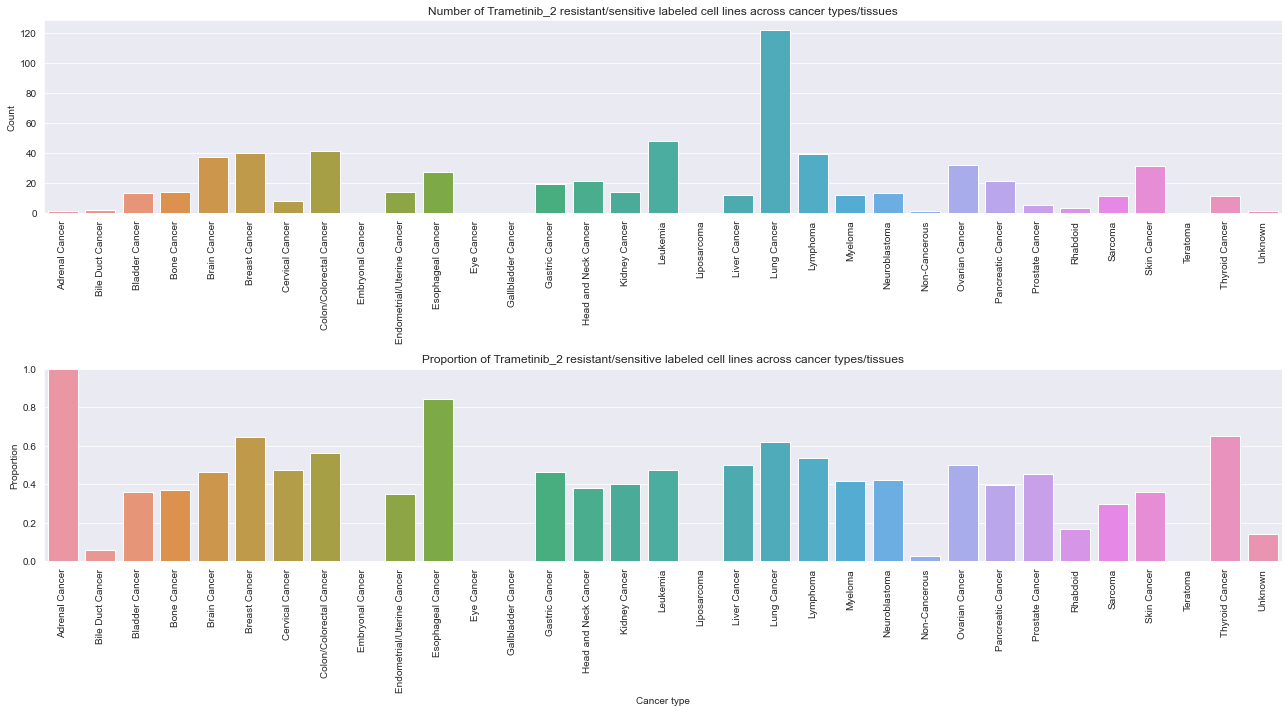

In [31]:
sns.set({'figure.figsize': (18, 10)})
fig, axarr = plt.subplots(2, 1)

sns.barplot(data=ccle_label_cancer_types, x='primary_disease',
            y='labeled_count', ax=axarr[0])
axarr[0].set_xticklabels(axarr[0].get_xticklabels(), rotation=90)
axarr[0].set_xlabel('')
axarr[0].set_ylabel('Count')
axarr[0].set_title(
    'Number of {} resistant/sensitive labeled cell lines across cancer types/tissues'.format(
        drug_to_plot)
)

sns.barplot(data=ccle_label_cancer_types, x='primary_disease',
            y='labeled_proportion', ax=axarr[1])
axarr[1].set_xticklabels(axarr[1].get_xticklabels(), rotation=90)
axarr[1].set_xlabel('Cancer type')
axarr[1].set_ylabel('Proportion')
axarr[1].set_ylim(0.0, 1.0)
axarr[1].set_title(
    'Proportion of {} resistant/sensitive labeled cell lines across cancer types/tissues'.format(
        drug_to_plot)
)

plt.tight_layout()

if output_plots:
    plt.savefig(output_plots_dir / '{}_dist.png'.format(drug_to_plot),
                dpi=200, bbox_inches='tight')

### Check distribution of sensitive/resistant samples across cancer types

In [32]:
drug_response_df['response'] = (drug_response_df.response
    .replace(to_replace='R', value='0')
    .replace(to_replace='S', value='1')
    .astype(int)
)
print(drug_response_df.shape)
drug_response_df.head()

(877, 6)


,sample_name,response,exprs,CNA,mutations,drug
0,683665,0,1,1,1,Trametinib
2,684052,0,1,1,1,Trametinib
3,684055,0,1,1,1,Trametinib
4,684057,0,1,1,1,Trametinib
5,684059,0,1,1,1,Trametinib


In [33]:
drug_cancer_types = (ccle_sample_info_df
    .loc[:, ['COSMICID', 'primary_disease']]
    .dropna()
)
drug_cancer_types['COSMICID'] = drug_cancer_types.COSMICID.astype(int)

print(drug_cancer_types.shape)
drug_cancer_types.head()

(981, 2)


,COSMICID,primary_disease
DepMap_ID,,
ACH-000288,905951,Breast Cancer
ACH-000467,1290907,Colon/Colorectal Cancer
ACH-002287,908482,Colon/Colorectal Cancer
ACH-000001,905933,Ovarian Cancer
ACH-000002,905938,Leukemia


In [34]:
ccle_sensitive_cancer_types = (drug_response_df
    .merge(drug_cancer_types, left_on='sample_name', right_on='COSMICID')
    .loc[:, ['sample_name', 'response', 'COSMICID', 'drug', 'primary_disease']]
    .query('sample_name in @ccle_drug_label_overlap')
    .groupby('primary_disease')
    .sum()
    .reset_index()
    .iloc[:, [0, 2]]
    .rename(columns={'response': 'sensitive_count'})
)

print(ccle_sensitive_cancer_types.shape)
ccle_sensitive_cancer_types.head()

(28, 2)


,primary_disease,sensitive_count
0,Adrenal Cancer,0
1,Bile Duct Cancer,2
2,Bladder Cancer,4
3,Bone Cancer,2
4,Brain Cancer,8


In [35]:
ccle_sensitive_cancer_types = (ccle_sensitive_cancer_types
    .merge(ccle_label_cancer_types, how='right', on='primary_disease')
    .fillna(value=0)
)
ccle_sensitive_cancer_types['sensitive_proportion'] = (
    ccle_sensitive_cancer_types['sensitive_count'] / ccle_sensitive_cancer_types['labeled_count']
)

print(ccle_sensitive_cancer_types.shape)
ccle_sensitive_cancer_types.head()

(33, 6)


,primary_disease,sensitive_count,labeled_count,count,labeled_proportion,sensitive_proportion
0,Adrenal Cancer,0.0,1.0,1,1.000000,0.000000
1,Bile Duct Cancer,2.0,2.0,35,0.057143,1.000000
2,Bladder Cancer,4.0,13.0,36,0.361111,0.307692
3,Bone Cancer,2.0,14.0,38,0.368421,0.142857
4,Brain Cancer,8.0,37.0,80,0.462500,0.216216


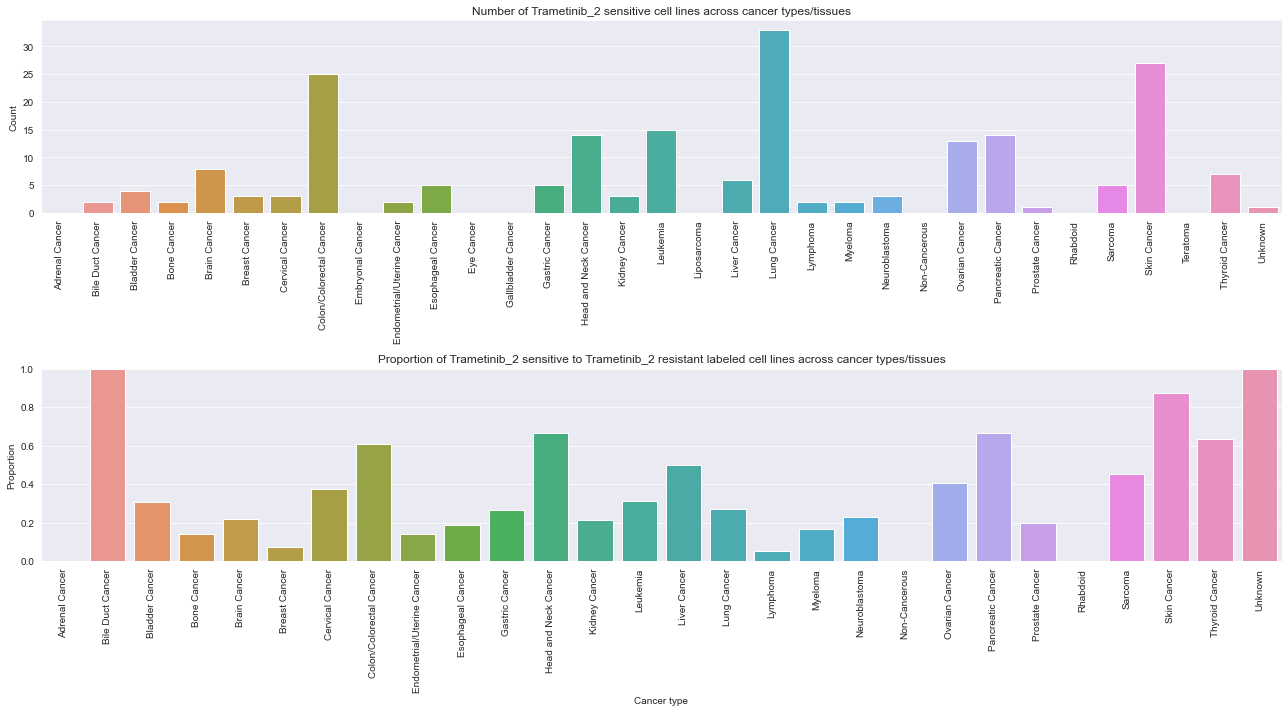

In [36]:
sns.set({'figure.figsize': (18, 10)})
fig, axarr = plt.subplots(2, 1)

sns.barplot(data=ccle_sensitive_cancer_types, x='primary_disease',
            y='sensitive_count', ax=axarr[0])
axarr[0].set_xticklabels(axarr[0].get_xticklabels(), rotation=90)
axarr[0].set_xlabel('')
axarr[0].set_ylabel('Count')
axarr[0].set_title(
    'Number of {} sensitive cell lines across cancer types/tissues'.format(
        drug_to_plot)
)

sns.barplot(data=ccle_sensitive_cancer_types[~ccle_sensitive_cancer_types.sensitive_proportion.isna()],
            x='primary_disease', y='sensitive_proportion', ax=axarr[1])
axarr[1].set_xticklabels(axarr[1].get_xticklabels(), rotation=90)
axarr[1].set_xlabel('Cancer type')
axarr[1].set_ylabel('Proportion')
axarr[1].set_ylim(0.0, 1.0)
axarr[1].set_title(
    'Proportion of {} sensitive to {} resistant labeled cell lines across cancer types/tissues'.format(
        drug_to_plot, drug_to_plot)
)

plt.tight_layout()

if output_plots:
    plt.savefig(output_plots_dir / '{}_sensitive_dist.png'.format(drug_to_plot),
                dpi=200, bbox_inches='tight')

In [37]:
cancer_type_to_annotation = {
    ct: ('liquid' if ct in cfg.ccle_liquid_cancer_types else 'solid')                                                                           
      for ct in ccle_sensitive_cancer_types.primary_disease.unique()                                                                                             
}

ccle_sensitive_cancer_types['liquid_or_solid'] = (
    ccle_sensitive_cancer_types.primary_disease.replace(cancer_type_to_annotation)
)
ccle_sensitive_cancer_types[ccle_sensitive_cancer_types.liquid_or_solid == 'liquid'].head()

,primary_disease,sensitive_count,labeled_count,count,labeled_proportion,sensitive_proportion,liquid_or_solid
16,Leukemia,15.0,48.0,101,0.475248,0.312500,liquid
20,Lymphoma,2.0,39.0,73,0.534247,0.051282,liquid
21,Myeloma,2.0,12.0,29,0.413793,0.166667,liquid


In [38]:
ccle_sensitive_liquid_solid = (ccle_sensitive_cancer_types
    .groupby('liquid_or_solid')
    .sum()
    .loc[:, ['sensitive_count', 'labeled_count']]
)
ccle_sensitive_liquid_solid['resistant_count'] = (
     ccle_sensitive_liquid_solid['labeled_count'] - ccle_sensitive_liquid_solid['sensitive_count']
)

ccle_sensitive_liquid_solid = (ccle_sensitive_liquid_solid
    .reset_index()
    .drop(columns=['labeled_count'])
    .melt(id_vars=['liquid_or_solid'], var_name='sensitive', value_name='count')
)
ccle_sensitive_liquid_solid.head()

,liquid_or_solid,sensitive,count
0,liquid,sensitive_count,19.0
1,solid,sensitive_count,186.0
2,liquid,resistant_count,80.0
3,solid,resistant_count,328.0


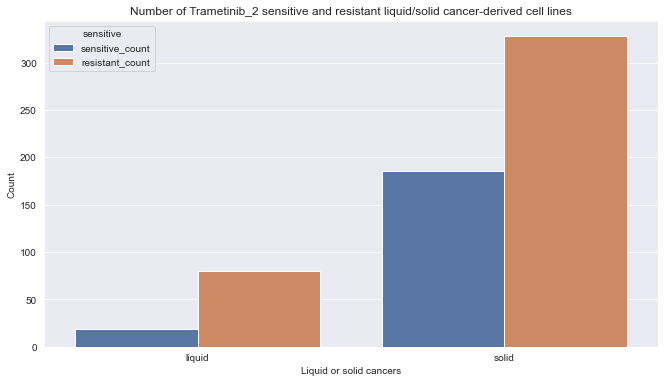

In [39]:
sns.set({'figure.figsize': (11, 6)})

sns.barplot(data=ccle_sensitive_liquid_solid.reset_index(), x='liquid_or_solid', y='count', hue='sensitive')
plt.xlabel('Liquid or solid cancers')
plt.ylabel('Count')
plt.title('Number of {} sensitive and resistant liquid/solid cancer-derived cell lines'.format(drug_to_plot))

if output_plots:
    plt.savefig(output_plots_dir / '{}_liquid_solid_dist.png'.format(drug_to_plot),
                dpi=200, bbox_inches='tight')